In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
from sklearn import svm
from imblearn.over_sampling import SMOTE



import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sylvie/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/sylvie/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /Users/sylvie/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
# Import data
data = pd.read_csv('Dataset1_labeled_data.csv')

In [3]:
df1 = pd.read_csv('twitter_hate_speench.csv')

In [6]:
# hate speech: 0
# offensive language: 1
# neither: 2

data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
# Check for NaN values:
data.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [8]:
# Size of dataset

data.shape
print('{} rows with {} columns'.format(data.shape[0],data.shape[1]))

24783 rows with 7 columns


In [9]:
# Distribution of Class
data['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [10]:
hate, offensive, neither = np.bincount(data['class'])
total = hate + offensive + neither
print(f'hate speech:\n    Total: {total}\n    hate: {hate} ({(100 * hate / total):.2f}% of total)\n')
print(f'offensive speech:\n    Total: {total}\n    Offensive: {offensive} ({(100 * offensive / total):.2f}% of total)\n')
print(f'neither:\n    Total: {total}\n    Neither: {neither} ({(100 * neither / total):.2f}% of total)\n')

hate speech:
    Total: 24783
    hate: 1430 (5.77% of total)

offensive speech:
    Total: 24783
    Offensive: 19190 (77.43% of total)

neither:
    Total: 24783
    Neither: 4163 (16.80% of total)



We have imbalanced dataset

In [4]:
df1 = df1[df1['label']==1][['label','tweet']]
df1


,label,tweet
13,1,@user #cnn calls #michigan middle school 'buil...
14,1,no comment! in #australia #opkillingbay #se...
17,1,retweet if you agree!
23,1,@user @user lumpy says i am a . prove it lumpy.
34,1,it's unbelievable that in the 21st century we'...
...,...,...
31934,1,lady banned from kentucky mall. @user #jcpenn...
31946,1,@user omfg i'm offended! i'm a mailbox and i'...
31947,1,@user @user you don't have the balls to hashta...
31948,1,"makes you ask yourself, who am i? then am i a..."


In [9]:
# Make a new column to highlight retweets
data['is_retweet'] = data['tweet'].apply(lambda x: x[:2]=='RT')
data['is_retweet'].sum()  # number of retweets

6484

In [10]:
# number of unique retweets
data.loc[data['is_retweet']].tweet.unique().size

6484

### Extracting substrings (@, #)

In [11]:
# Who is being retweeted?
# Who is being tweeted at/mentioned?
# What hashtags are being used?

# Create functions

def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   

In [12]:
# Make new columns for retweeted usernames, mentioned usernames and hashtags

data['retweeted'] = data.tweet.apply(find_retweeted)
data['mentioned'] = data.tweet.apply(find_mentioned)
data['hashtags'] = data.tweet.apply(find_hashtags)

In [13]:
# Have a look at the new columns

data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,is_retweet,retweeted,mentioned,hashtags
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,False,[@mayasolovely],[],[]
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,False,[@mleew17],[],[]
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,False,[@UrKindOfBrand],[],[]
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,False,[@C_G_Anderson],[@viva_based],[]
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,False,[@ShenikaRoberts],[],[]


#### What hashtags are being used 

In [10]:
# Take the rows from the hashtag columns where there are actually hashtags

hashtags_list_data = data.loc[
                       data.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]
hashtags_list_data.head()

,hashtags
37,[#Shots]
41,[#SevenOne]
45,[#HappyHumpDay]
72,[#ahmesehwetness]
73,"[#Eaglesnation, #Eagles]"


In [11]:
# Create dataframe where each use of hashtag gets its own row

flattened_hashtags_data = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_data.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
flattened_hashtags_data.head()

,hashtag
0,#Shots
1,#SevenOne
2,#HappyHumpDay
3,#ahmesehwetness
4,#Eaglesnation


In [12]:
flattened_hashtags_data.shape

(3490, 1)

In [13]:
# Number of unique hashtags

flattened_hashtags_data['hashtag'].unique().size

2251

In [14]:
# Count of appearances of each hashtag
popular_hashtags = flattened_hashtags_data.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_hashtags.head(10)

,hashtag,counts
0,#Yankees,94
1,#iphone,50
2,#ipad,48
3,#sex,48
4,#android,48
5,#porn,48
6,#xxx,48
7,#tcot,41
8,#hoosiers,23
9,#morningjoe,22


#### Who is being retweeted 

In [15]:
# Take the rows from the retweeted columns where there are actually hashtags

retweeted_list_data = data.loc[
                       data.retweeted.apply(
                           lambda retweeted_list: retweeted_list !=[]
                       ),['retweeted']]
retweeted_list_data.head()


,retweeted
0,[@mayasolovely]
1,[@mleew17]
2,[@UrKindOfBrand]
3,[@C_G_Anderson]
4,[@ShenikaRoberts]


In [16]:
# Create dataframe where each use of retweeted gets its own row

flattened_retweeted_data = pd.DataFrame(
    [retweeted for retweeted_list in retweeted_list_data.retweeted
    for retweeted in retweeted_list],
    columns=['retweeted'])
flattened_retweeted_data.head()


,retweeted
0,@mayasolovely
1,@mleew17
2,@UrKindOfBrand
3,@C_G_Anderson
4,@ShenikaRoberts


In [17]:
flattened_retweeted_data.shape

(7073, 1)

In [18]:
# Number of unique retweeted

flattened_retweeted_data['retweeted'].unique().size

5296

In [19]:
# Count of appearances of each retweeted
popular_retweeted = flattened_retweeted_data.groupby('retweeted').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_retweeted.head(10)

,retweeted,counts
0,@iDntWearCondoms,25
1,@Yankees,24
2,@JoeBudden,23
3,@CauseWereGuys,22
4,@KINGTUNCHI_,19
5,@FriendlyAssh0le,19
6,@KingHorseDick,19
7,@FunnyPicsDepot,15
8,@CuhCuhCuh,15
9,@SteveStfler,14


#### Who is being tweeted at/mentioned

In [20]:
# Take the rows from the mentioned columns where there are actually hashtags

mentioned_list_data = data.loc[
                       data.mentioned.apply(
                           lambda mentioned_list: mentioned_list !=[]
                       ),['mentioned']]
mentioned_list_data.head()



,mentioned
3,[@viva_based]
5,[@T_Madison_x]
7,[@selfiequeenbri]
9,[@rhythmixx_]
52,[@DaRealKha]


In [21]:
# Create dataframe where each use of mentioned gets its own row

flattened_mentioned_data = pd.DataFrame(
    [mentioned for mentioned_list in mentioned_list_data.mentioned
    for mentioned in mentioned_list],
    columns=['mentioned'])
flattened_mentioned_data.head()

,mentioned
0,@viva_based
1,@T_Madison_x
2,@selfiequeenbri
3,@rhythmixx_
4,@DaRealKha


In [22]:
flattened_mentioned_data.shape

(10958, 1)

In [23]:
# Number of unique retweeted

flattened_mentioned_data['mentioned'].unique().size

7039

In [24]:
# Count of appearances of each retweeted
popular_mentioned = flattened_mentioned_data.groupby('mentioned').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_mentioned.head(10)

,mentioned,counts
0,@kieffer_jason,101
1,@Yankees,46
2,@Huntermoore,30
3,@Buckm00se,23
4,@sbsylvester,22
5,@what_evaittakes,20
6,@VoiceOfDStreetz,19
7,@JawShoeeAhhh,18
8,@Leelucas_,18
9,@viaNAWF,18


### Wordcloud for 3 categories of tweets

<class 'set'>


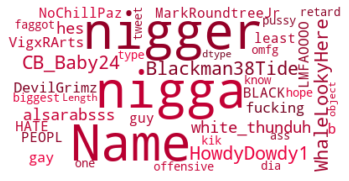

In [212]:
# Hate Speech

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

print(type(STOPWORDS))

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(data.loc[data["class"]== 0].tweet))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

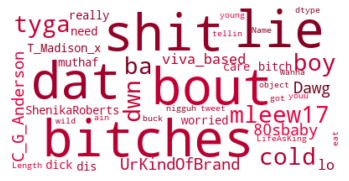

In [213]:
# Offensive Language 

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(data.loc[data["class"]== 1].tweet))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

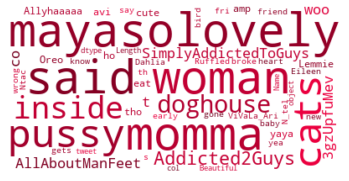

In [214]:
# Neither

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60, 
                          random_state=42
                         ).generate(str(data.loc[data["class"]== 2].tweet))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

### Cleaning Unstructured Text Data

In [5]:
# Create functions

def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z0-9-_]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z0-9-_]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [6]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]\\\\\^_`{|}~•@#'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet = re.sub('amp', '', tweet) # remove amp
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [7]:
data['clean_tweet'] = data.tweet.apply(clean_tweet)
data.head(30)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain clean hous man alway take trash
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st p...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",shit blow claim faith somebodi still fuck hoe
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ...",sit hate anoth bitch got much shit go
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,caus tire big bitch come us skinni girl
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ...",might get ya bitch back that
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria...",hobbi includ fight mariam bitch


In [8]:
df1['clean_tweet'] = df1.tweet.apply(clean_tweet)
df1

,label,tweet,clean_tweet
13,1,@user #cnn calls #michigan middle school 'buil...,cnn call michigan middl school build wall cha...
14,1,no comment! in #australia #opkillingbay #se...,comment australia opkillingbay seashepherd hel...
17,1,retweet if you agree!,retweet agre
23,1,@user @user lumpy says i am a . prove it lumpy.,lumpi say prove lumpi
34,1,it's unbelievable that in the 21st century we'...,unbeliev st centuri need someth like neverump ...
...,...,...,...
31934,1,lady banned from kentucky mall. @user #jcpenn...,adi ban kentucki mall jcpenni kentucki
31946,1,@user omfg i'm offended! i'm a mailbox and i'...,omfg offend mailbox proud mailboxprid liberalism
31947,1,@user @user you don't have the balls to hashta...,ball hashtag say weasel away lumpi toni dipshit
31948,1,"makes you ask yourself, who am i? then am i a...",make ask anybodi god oh thank god


In [9]:
df1['label'] = 0
df1.rename(columns = {'label': 'class'}, inplace = True)
df1

,class,tweet,clean_tweet
13,0,@user #cnn calls #michigan middle school 'buil...,cnn call michigan middl school build wall cha...
14,0,no comment! in #australia #opkillingbay #se...,comment australia opkillingbay seashepherd hel...
17,0,retweet if you agree!,retweet agre
23,0,@user @user lumpy says i am a . prove it lumpy.,lumpi say prove lumpi
34,0,it's unbelievable that in the 21st century we'...,unbeliev st centuri need someth like neverump ...
...,...,...,...
31934,0,lady banned from kentucky mall. @user #jcpenn...,adi ban kentucki mall jcpenni kentucki
31946,0,@user omfg i'm offended! i'm a mailbox and i'...,omfg offend mailbox proud mailboxprid liberalism
31947,0,@user @user you don't have the balls to hashta...,ball hashtag say weasel away lumpi toni dipshit
31948,0,"makes you ask yourself, who am i? then am i a...",make ask anybodi god oh thank god


In [10]:
bigdata = pd.concat([data, df1], ignore_index=True, sort=False)
bigdata

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet
0,0.0,3.0,0.0,0.0,3.0,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain clean hous man alway take trash
1,1.0,3.0,0.0,3.0,0.0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st p...
2,2.0,3.0,0.0,3.0,0.0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit
3,3.0,3.0,0.0,2.0,1.0,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
4,4.0,6.0,0.0,6.0,0.0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya
...,...,...,...,...,...,...,...,...
27020,NaN,NaN,NaN,NaN,NaN,0,lady banned from kentucky mall. @user #jcpenn...,adi ban kentucki mall jcpenni kentucki
27021,NaN,NaN,NaN,NaN,NaN,0,@user omfg i'm offended! i'm a mailbox and i'...,omfg offend mailbox proud mailboxprid liberalism
27022,NaN,NaN,NaN,NaN,NaN,0,@user @user you don't have the balls to hashta...,ball hashtag say weasel away lumpi toni dipshit
27023,NaN,NaN,NaN,NaN,NaN,0,"makes you ask yourself, who am i? then am i a...",make ask anybodi god oh thank god


In [30]:
# Converting Text to Numbers

X = bigdata['clean_tweet']
y = bigdata['class']

from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer()
X = tfidfconverter.fit_transform(bigdata['clean_tweet']).toarray()

In [31]:
# Split our data into a training set and a testing set


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic regression model

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


# Logistic Regression:
text_clf_logr = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression()),
])

# Naïve Bayes:
text_clf_nb = Pipeline([('countVec', CountVectorizer()),
                     ('clf', MultinomialNB()),
])

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])



## Logistic Regression:

In [33]:
text_clf_logr.fit(X_train, y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [34]:
# Form a prediction set
predictions = text_clf_logr.predict(X_test)

NotFittedError: Vocabulary not fitted or provided

In [54]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[  56  199   35]
 [  43 3686  103]
 [   7  126  702]]


In [55]:
# OR
# Results

pd.crosstab(y_test, predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1,2
Actual,,,
0,56,199,35
1,43,3686,103
2,7,126,702


In [56]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.53      0.19      0.28       290
           1       0.92      0.96      0.94      3832
           2       0.84      0.84      0.84       835

    accuracy                           0.90      4957
   macro avg       0.76      0.67      0.69      4957
weighted avg       0.88      0.90      0.88      4957



In [43]:
## Seems like we need to handle the imbalanced dataset problem

## Naïve Bayes:

In [35]:
text_clf_nb.fit(X_train, y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [45]:
# Form a prediction set
predictions = text_clf_nb.predict(X_test)

In [46]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[  26  395   44]
 [  21 6229   85]
 [  12  482  885]]


In [47]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.44      0.06      0.10       465
           1       0.88      0.98      0.93      6335
           2       0.87      0.64      0.74      1379

    accuracy                           0.87      8179
   macro avg       0.73      0.56      0.59      8179
weighted avg       0.85      0.87      0.85      8179



## Linear SVC:

In [48]:
text_clf_lsvc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [49]:
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)

In [50]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))


[[ 110  313   42]
 [ 115 6031  189]
 [  19  211 1149]]


In [51]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.45      0.24      0.31       465
           1       0.92      0.95      0.94      6335
           2       0.83      0.83      0.83      1379

    accuracy                           0.89      8179
   macro avg       0.73      0.67      0.69      8179
weighted avg       0.88      0.89      0.88      8179



## Test traditional models

In [11]:
df = bigdata['clean_tweet']
target = bigdata['class']

In [12]:
# Tokenizing
# function to tokenize 

def unfiltered_tokens(text):
    dirty_tokens = nltk.word_tokenize(text)
    return dirty_tokens

In [13]:
# applying this function to the `clean_tweets` column

processed_data = list(map(unfiltered_tokens, df))

In [14]:
# morphing `processed_data` into a readable list

flat_unfiltered = [item for sublist in processed_data for item in sublist]

In [15]:
# getting frequency distribution
corpus_freqdist = FreqDist(flat_unfiltered)

# top 20 words in the corpus
corpus_freqdist.most_common(20)

[('bitch', 11485),
 ('hoe', 4353),
 ('like', 3007),
 ('fuck', 2284),
 ('pussi', 2274),
 ('nigga', 2008),
 ('get', 1838),
 ('got', 1634),
 ('ass', 1614),
 ('u', 1339),
 ('shit', 1322),
 ('trash', 1172),
 ('go', 959),
 ('know', 909),
 ('one', 815),
 ('love', 809),
 ('look', 801),
 ('want', 788),
 ('say', 768),
 ('make', 756)]

In [16]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

# Our corpus has a vocabulary of 17963. 
# This would also be the number of columns in the sparse matrix after we vectorize the data later.

17963

In [17]:
# Lemmatization: it reduces each word into a linguistically valid lemma, or root word. 
# It does this through linguistic mappings, using the WordNet lexical database.

# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [18]:
X_lem = lemmatized_output
y_lem = target

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.2, random_state= 20)

# using tf_idf vectorizor
tfidf = TfidfVectorizer()

In [20]:
# sparse matrix format with 15671 stored elements
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

In [21]:
# taking a quick look of the non zero elements
non_zero_cols = tfidf_data_train.nnz / float(tfidf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

# 99.9% of the columns contain a zero, meaning that's a very sparse matrix

Average Number of Non-Zero Elements in Vectorized Articles: 7.06572617946346
Percentage of columns containing ZERO: 0.9995532545410051


In [22]:
# creating single df for training set
X_train_df = pd.DataFrame(data=tfidf_data_train, index=None, columns=['clean_tweet']) 
y_train_df = pd.DataFrame(data=y_train, index=None, columns=['class']) 
# joining them
training = pd.concat([X_train_df, y_train_df], axis=1)

In [23]:
training.head(2)

,clean_tweet,class
0,"(0, 1274)\t0.4743208544394475\n (0, 4847)\t...",2.0
1,"(0, 6359)\t0.44486943511645427\n (0, 8059)\...",1.0


In [24]:
# separate minority and majority classes
hate = training[training['class']==0]
offensive = training[training['class']==1]
neither = training[training['class']==2]


In [25]:
print(hate.shape)
print(offensive.shape)
print(neither.shape)

(2975, 2)
(15281, 2)
(3364, 2)


We can see that this data has a huge class imbalance. After running a baseline, we can try oversampling the minority class (hate speech) with SMOTE and undersampling the majority class with Tomek Links.

### Baseline Random Forest

In [26]:
rf_baseline = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)
# adding class_weight='balanced' increased accuracy & precision but decreased F1

In [27]:
rf_baseline.fit(tfidf_data_train, y_train)
rf_test_preds = rf_baseline.predict(tfidf_data_test)

rf_baseline_report = classification_report(y_test, rf_test_preds)
print(rf_baseline_report)

              precision    recall  f1-score   support

           0       0.77      0.68      0.72       697
           1       0.93      0.95      0.94      3909
           2       0.83      0.82      0.83       799

    accuracy                           0.90      5405
   macro avg       0.84      0.82      0.83      5405
weighted avg       0.89      0.90      0.90      5405



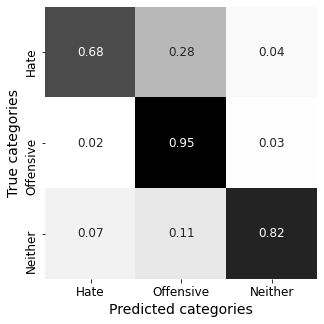

In [28]:
import seaborn
conf_matrix = confusion_matrix(y_test, rf_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

### Baseline Logistic Regression

In [29]:
logreg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)

In [30]:
logreg_baseline.fit(tfidf_data_train, y_train)
logreg_test_preds = logreg_baseline.predict(tfidf_data_test)

logreg_baseline_report = classification_report(y_test, logreg_test_preds)
print(logreg_baseline_report)

              precision    recall  f1-score   support

           0       0.58      0.78      0.67       697
           1       0.97      0.86      0.91      3909
           2       0.74      0.91      0.82       799

    accuracy                           0.86      5405
   macro avg       0.76      0.85      0.80      5405
weighted avg       0.88      0.86      0.87      5405



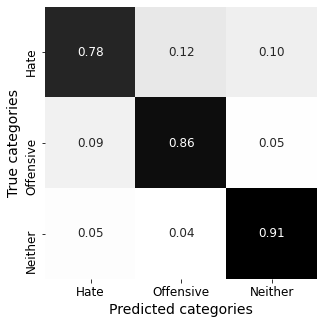

In [31]:
conf_matrix = confusion_matrix(y_test, logreg_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

### Baseline with SMOTE

In [34]:
sm = SMOTE(random_state=35)
smote_X_train, smote_y_train = sm.fit_sample(tfidf_data_train, y_train)

In [35]:
smote_logreg = LogisticRegression(penalty='l2', random_state=35)

smote_logreg.fit(smote_X_train, smote_y_train)
smote_logreg_test_preds = smote_logreg.predict(tfidf_data_test)

smote_logreg_report = classification_report(y_test, smote_logreg_test_preds)
print(smote_logreg_report)

              precision    recall  f1-score   support

           0       0.61      0.75      0.67       697
           1       0.96      0.88      0.92      3909
           2       0.76      0.89      0.82       799

    accuracy                           0.87      5405
   macro avg       0.78      0.84      0.80      5405
weighted avg       0.88      0.87      0.87      5405



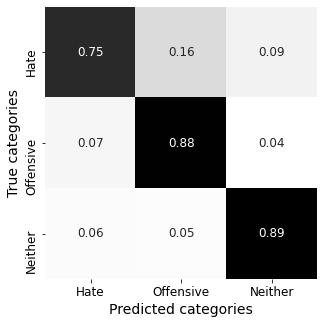

In [36]:
conf_matrix = confusion_matrix(y_test, smote_logreg_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

### Baseline with Tomek Links¶

In [37]:
# Under-sample the majority class (offensive)

from collections import Counter
from imblearn.under_sampling import TomekLinks # doctest: +NORMALIZE_WHITESPACE

tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(tfidf_data_train, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

# It removed 230 values from the 'offensive language' class and 144 values from 'neither' class

Resampled dataset shape Counter({1: 15051, 2: 3220, 0: 2975})


In [38]:
tomek_logreg = LogisticRegression(penalty='l2', random_state=55)

tomek_logreg.fit(tomek_X_train, tomek_y_train)
tomek_logreg_test_preds = tomek_logreg.predict(tfidf_data_test)

tomek_logreg_report = classification_report(y_test, tomek_logreg_test_preds)
print(tomek_logreg_report)

              precision    recall  f1-score   support

           0       0.81      0.63      0.71       697
           1       0.92      0.96      0.94      3909
           2       0.82      0.83      0.83       799

    accuracy                           0.89      5405
   macro avg       0.85      0.80      0.82      5405
weighted avg       0.89      0.89      0.89      5405



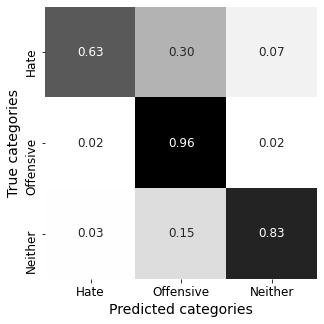

In [39]:
conf_matrix = confusion_matrix(y_test, tomek_logreg_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

### Grid Search 

In [40]:
# creating the model
baseline_model = LogisticRegression(class_weight='balanced', random_state=50)

In [41]:
# creating param_dict
param_dict={'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'newton-cg', 'sag'], 'C':
[100, 10, 1.0, 0.1, 0.01]}

In [42]:
# instantiate Grid Search CV with F1 metric
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='weighted')
grid_baseline = GridSearchCV(baseline_model, param_dict, cv=5, scoring= f1, verbose=1)

In [43]:
# fit the grid search to our data
grid_baseline.fit(tfidf_data_train, y_train)

# generate score with .best_score_ and hyperparemeters with .best_params_
print('F1 Score:', grid_baseline.best_score_)
print('Best Hyperparameters:', grid_baseline.best_params_)
print('Model object with best parameters: ')
print(grid_baseline.best_estimator_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


F1 Score: 0.8873100939155865
Best Hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Model object with best parameters: 
LogisticRegression(class_weight='balanced', random_state=50, solver='liblinear')


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.3min finished


In [44]:
grid_base_test_preds = grid_baseline.best_estimator_.predict(tfidf_data_test)

grid_base_logreg_report = classification_report(y_test, grid_base_test_preds)
print(grid_base_logreg_report)

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       697
           1       0.96      0.91      0.93      3909
           2       0.75      0.90      0.81       799

    accuracy                           0.89      5405
   macro avg       0.80      0.85      0.82      5405
weighted avg       0.89      0.89      0.89      5405



### Running This Tuned Baseline on SMOTE Data

In [48]:
# best model according to grid search
smote_tuned = LogisticRegression(C=1.0, class_weight='balanced', penalty='l1', random_state=50,
                   solver='liblinear')

smote_tuned.fit(smote_X_train, smote_y_train)
smote_tuned_test_preds = smote_tuned.predict(tfidf_data_test)

smote_tuned_logreg_report = classification_report(y_test, smote_tuned_test_preds)
print(smote_tuned_logreg_report)

              precision    recall  f1-score   support

           0       0.60      0.80      0.69       697
           1       0.96      0.88      0.92      3909
           2       0.78      0.89      0.83       799

    accuracy                           0.87      5405
   macro avg       0.78      0.86      0.81      5405
weighted avg       0.89      0.87      0.88      5405



### Running This Tuned Baseline on TOMEK Data

In [58]:
tomek_tuned = LogisticRegression(C=1.0, class_weight='balanced', penalty='l1', random_state=50,
                   solver='liblinear')
tomek_tuned.fit(tomek_X_train, tomek_y_train)
tomek_tuned_test_preds = tomek_tuned.predict(tfidf_data_test)
tomek_tuned_logreg_report = classification_report(y_test, tomek_tuned_test_preds)
print(tomek_tuned_logreg_report)

              precision    recall  f1-score   support

           0       0.66      0.77      0.71       697
           1       0.96      0.90      0.93      3909
           2       0.77      0.90      0.83       799

    accuracy                           0.88      5405
   macro avg       0.80      0.86      0.82      5405
weighted avg       0.90      0.88      0.89      5405



### Baseline Naive Bayes

In [49]:
baseline_bayes = MultinomialNB(alpha = .01)

baseline_bayes.fit(tfidf_data_train, y_train)
bayes_test_preds = baseline_bayes.predict(tfidf_data_test)

bayes_baseline_report = classification_report(y_test, bayes_test_preds)
print(bayes_baseline_report)

              precision    recall  f1-score   support

           0       0.79      0.48      0.60       697
           1       0.84      0.96      0.89      3909
           2       0.73      0.45      0.56       799

    accuracy                           0.82      5405
   macro avg       0.78      0.63      0.68      5405
weighted avg       0.81      0.82      0.81      5405



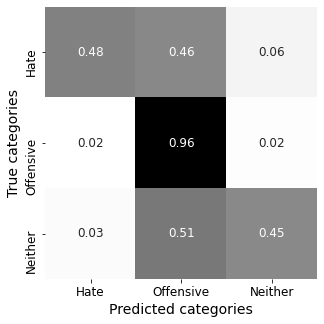

In [50]:
confusion_matrix = confusion_matrix(y_test, bayes_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

### Baseline SVM

In [51]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

SVM_baseline.fit(tfidf_data_train, y_train)
SVM_test_preds = SVM_baseline.predict(tfidf_data_test)

SVM_baseline_report = classification_report(y_test, SVM_test_preds)
print(SVM_baseline_report)

              precision    recall  f1-score   support

           0       0.62      0.79      0.69       697
           1       0.97      0.89      0.93      3909
           2       0.76      0.91      0.83       799

    accuracy                           0.88      5405
   macro avg       0.78      0.86      0.82      5405
weighted avg       0.89      0.88      0.88      5405



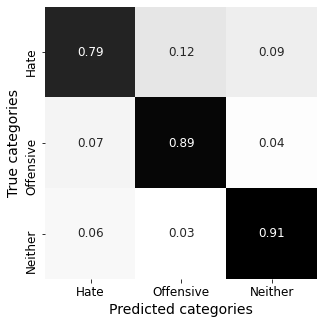

In [55]:
conf_matrix = confusion_matrix(y_test, SVM_test_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = conf_matrix[i,:]/float(conf_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

Overall, the Tuned Baseline Logistic Regression on SMOTE data model performed the best across recall(0.80) and F1(0.69). 

In [60]:
# Pickling final model for the interactive webapp
import pickle
pickle_out = open("./webapp/pickle/final_logreg_model.pkl","wb")
pickle.dump(smote_tuned, pickle_out)
pickle_out.close()

In [62]:
## pickling X_train for future use
pickle_out = open("./webapp/pickle/X_train.pkl","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()